In [2]:
import os  # For file and directory operations
import yaml  # For reading YAML configuration files
import pickle
import pandas as pd

In [3]:
with open("../config/path.yaml", "r") as file:  # Replace with your path to your YAML file
    config = yaml.safe_load(file) 

data_path = config.get("raw_data") 
if not data_path:
    raise ValueError("Data path not found in the YAML configuration.")

print(f"Data path loaded from YAML: {data_path}") 

Data path loaded from YAML: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy


In [4]:
if not os.path.exists(data_path):
    raise FileNotFoundError(f"The specified data path does not exist: {data_path}")
if not os.path.isdir(data_path):
    raise NotADirectoryError(f"The specified data path is not a directory: {data_path}")

# List all subfolders (patients) in the data path
patient_folders = [os.path.join(data_path, folder) for folder in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, folder))]

print(f"Found {len(patient_folders)} patient folders in the data path.")  # Optional: Print the number of patient folders found

# Optional: Print the first few patient folder paths for verification
for folder in patient_folders[:5]:
    print(f"Patient folder: {folder}")

Found 15 patient folders in the data path.
Patient folder: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy\S1
Patient folder: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy\S10
Patient folder: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy\S11
Patient folder: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy\S12
Patient folder: C:/Users/darte/Documents/Projects/healthcare-anomaly/data/PPG_FieldStudy\S13


In [5]:
# patient_dataframes = {}

# # Iterate through patient folders and process .pkl files
# for folder in patient_folders:
#     patient_id = os.path.basename(folder)
#     pkl_file = os.path.join(folder, f"{patient_id}.pkl")
    
#     if not os.path.exists(pkl_file):
#         print(f"Warning: .pkl file not found for patient {patient_id}. Skipping...")
#         continue

#     # Load the .pkl file
#     try:
#         with open(pkl_file, "rb") as file:  # Use binary mode
#             data = pickle.load(file, encoding="latin1")  # Specify encoding
#     except Exception as e:
#         print(f"Error decoding .pkl file for patient {patient_id}: {e}")
#         continue
    
#     # Extract necessary parts
#     try:
#         labels = data.get("label", [])
#         activity = data.get("activity", [])
#         chest_signals = data.get("signal", {}).get("chest", {})
#         wrist_signals = data.get("signal", {}).get("wrist", {})
        
#         # Create a DataFrame for the patient
#         df = pd.DataFrame({
#             "label": labels,
#             "activity": activity,
#             "chest_acc": chest_signals.get("ACC", []),
#             "wrist_bvp": wrist_signals.get("BVP", []),
#         })
        
#         # Store the DataFrame
#         patient_dataframes[patient_id] = df
#         print(f"Processed data for patient {patient_id}.")
    
#     except Exception as e:
#         print(f"Error processing patient {patient_id}: {e}")

# # Example: Access the DataFrame for a specific patient
# # example_patient_id = list(patient_dataframes.keys())[0]
# # print(patient_dataframes[example_patient_id].head())

In [30]:
import numpy as np

patient_dataframes = {}

# Function to segment data with a sliding window
def segment_signal(signal, window_size, step_size, sampling_rate):
    num_samples = len(signal)
    window_samples = int(window_size * sampling_rate)
    step_samples = int(step_size * sampling_rate)
    segments = [
        signal[i:i + window_samples]
        for i in range(0, num_samples - window_samples + 1, step_samples)
    ]
    return segments

# Iterate through patient folders and process .pkl files
for folder in patient_folders:
    patient_id = os.path.basename(folder)
    pkl_file = os.path.join(folder, f"{patient_id}.pkl")
    
    if not os.path.exists(pkl_file):
        print(f"Warning: .pkl file not found for patient {patient_id}. Skipping...")
        continue

    # Load the .pkl file
    try:
        with open(pkl_file, "rb") as file:
            data = pickle.load(file, encoding="latin1")  # Use latin1 encoding for compatibility
    except Exception as e:
        print(f"Error decoding .pkl file for patient {patient_id}: {e}")
        continue
    
    # Extract necessary parts
    try:
        labels = data.get("label", [])
        wrist_signals = data.get("signal", {}).get("wrist", {})
        bvp_signal = wrist_signals.get("BVP", [])
        acc_signal = wrist_signals.get("ACC", [])
        
        # Ensure signals are numpy arrays for easier processing
        bvp_signal = np.array(bvp_signal)
        acc_signal = np.array(acc_signal)
        labels = np.array(labels)
        
        # Segment signals using an 8-second window with a 2-second shift
        bvp_segments = segment_signal(bvp_signal, window_size=8, step_size=2, sampling_rate=64)
        acc_segments = segment_signal(acc_signal, window_size=8, step_size=2, sampling_rate=32)
        
        # Ensure the number of segments matches the labels
        min_segments = min(len(bvp_segments), len(acc_segments))
        bvp_segments = bvp_segments[:min_segments]
        acc_segments = acc_segments[:min_segments]
        labels = labels[:min_segments]
        
        # Create a DataFrame for the patient
        df = pd.DataFrame({
            "label": labels, #represents ground truth heart rate
            "bvp_segment": bvp_segments,
            "acc_segment": acc_segments,
        })
        
        # Store the DataFrame
        patient_dataframes[patient_id] = df
        print(f"Processed data for patient {patient_id}.")
    
    except Exception as e:
        print(f"Error processing patient {patient_id}: {e}")

# Example: Access the DataFrame for a specific patient
if patient_dataframes:
    example_patient_id = list(patient_dataframes.keys())[0]
    print(patient_dataframes[example_patient_id].head())
else:
    print("No patient dataframes were created.")

Processed data for patient S1.
Processed data for patient S10.
Processed data for patient S11.
Processed data for patient S12.
Processed data for patient S13.
Processed data for patient S14.
Processed data for patient S15.
Processed data for patient S2.
Processed data for patient S3.
Processed data for patient S4.
Processed data for patient S5.
Processed data for patient S6.
Processed data for patient S7.
Processed data for patient S8.
Processed data for patient S9.
       label                                        bvp_segment  \
0  49.611369  [[7.28], [6.33], [5.46], [4.6], [3.74], [2.86]...   
1  50.323992  [[6.34], [9.78], [12.97], [15.82], [18.17], [1...   
2  52.708336  [[7.7], [6.02], [4.23], [2.46], [0.74], [-0.93...   
3  55.640794  [[-120.35], [-108.51], [-98.97], [-91.45], [-8...   
4  57.658406  [[-7.06], [-10.67], [-14.96], [-19.6], [-24.25...   

                                         acc_segment  
0  [[-0.765625, -0.078125, 0.671875], [-0.765625,...  
1  [[-0.75, -0.0

In [31]:
# Check if patient 1's data exists
patient_id = "S1"  # Replace with the correct patient ID
if patient_id in patient_dataframes:
    num_rows = patient_dataframes[patient_id].shape[0]
    print(f"Patient {patient_id} has {num_rows} rows in their DataFrame.")
else:
    print(f"No data found for patient {patient_id}.")

Patient S1 has 4603 rows in their DataFrame.


In [32]:
# Check if patient 1's data exists
patient_id = "S10"  # Replace with the correct patient ID
if patient_id in patient_dataframes:
    df = patient_dataframes[patient_id]
    print(f"First row for patient {patient_id}:\n{df.head(1)}")
    print(f"Last row for patient {patient_id}:\n{df.tail(1)}")
else:
    print(f"No data found for patient {patient_id}.")

First row for patient S10:
       label                                        bvp_segment  \
0  64.282356  [[7.87], [7.03], [6.33], [5.69], [4.94], [3.97...   

                                         acc_segment  
0  [[-0.765625, 0.25, 0.59375], [-0.765625, 0.265...  
Last row for patient S10:
          label                                        bvp_segment  \
5320  85.709338  [[22.96], [22.2], [21.18], [19.87], [18.32], [...   

                                            acc_segment  
5320  [[-0.796875, 0.296875, 0.03125], [-0.765625, 0...  


In [33]:
print(f"First BVP segment for patient {patient_id}: {bvp_segments[0]}")
print(f"Length of first BVP segment: {len(bvp_segments[0])}")

First BVP segment for patient S10: [[-8.900e-01]
 [-1.410e+00]
 [-1.660e+00]
 [-1.790e+00]
 [-1.990e+00]
 [-2.430e+00]
 [-3.150e+00]
 [-4.110e+00]
 [-5.180e+00]
 [-6.240e+00]
 [-7.250e+00]
 [-8.310e+00]
 [-9.570e+00]
 [-1.119e+01]
 [-1.316e+01]
 [-1.524e+01]
 [-1.697e+01]
 [-1.786e+01]
 [-1.752e+01]
 [-1.590e+01]
 [-1.331e+01]
 [-1.030e+01]
 [-7.400e+00]
 [-4.960e+00]
 [-3.020e+00]
 [-1.440e+00]
 [-5.000e-02]
 [ 1.260e+00]
 [ 2.430e+00]
 [ 3.430e+00]
 [ 4.220e+00]
 [ 4.880e+00]
 [ 5.500e+00]
 [ 6.140e+00]
 [ 6.800e+00]
 [ 7.400e+00]
 [ 7.870e+00]
 [ 8.120e+00]
 [ 8.120e+00]
 [ 7.840e+00]
 [ 7.300e+00]
 [ 6.590e+00]
 [ 5.870e+00]
 [ 5.360e+00]
 [ 5.200e+00]
 [ 5.350e+00]
 [ 5.560e+00]
 [ 5.480e+00]
 [ 4.880e+00]
 [ 3.740e+00]
 [ 2.370e+00]
 [ 1.230e+00]
 [ 7.100e-01]
 [ 9.300e-01]
 [ 1.670e+00]
 [ 2.470e+00]
 [ 2.860e+00]
 [ 2.590e+00]
 [ 1.670e+00]
 [ 3.900e-01]
 [-9.000e-01]
 [-1.880e+00]
 [-2.420e+00]
 [-2.640e+00]
 [-2.840e+00]
 [-3.330e+00]
 [-4.330e+00]
 [-5.840e+00]
 [-7.620e+00]

In [34]:
# Check if patient 1's data exists
patient_id = "S1"  # Replace with the correct patient ID
if patient_id in patient_dataframes:
    df = patient_dataframes[patient_id]
    min_label = df["label"].min()
    max_label = df["label"].max()
    print(f"Patient {patient_id} - Min label: {min_label}, Max label: {max_label}")
else:
    print(f"No data found for patient {patient_id}.")

Patient S1 - Min label: 41.86246685820639, Max label: 150.15457212632637


In [11]:
import numpy as np

# Example feature extraction function
def extract_features(bvp_segment, acc_segment):
    features = {
        "bvp_mean": np.mean(bvp_segment),
        "bvp_std": np.std(bvp_segment),
        "bvp_max": np.max(bvp_segment),
        "bvp_min": np.min(bvp_segment),
        "acc_mean": np.mean(acc_segment),
        "acc_std": np.std(acc_segment),
        "acc_max": np.max(acc_segment),
        "acc_min": np.min(acc_segment),
        
    }
    return features

# Prepare the dataset for training
training_data = []
training_labels = []

for patient_id, df in patient_dataframes.items():
    for _, row in df.iterrows():
        features = extract_features(row["bvp_segment"], row["acc_segment"])
        training_data.append(features)
        training_labels.append(row["label"])  # Adjust if anomaly detection requires binary labels

# Convert to DataFrame for easier handling
training_df = pd.DataFrame(training_data)
training_df["label"] = training_labels

print(training_df.head())

   bvp_mean    bvp_std  bvp_max  bvp_min  acc_mean   acc_std  acc_max  \
0 -2.175781  61.065445   173.25  -176.79 -0.184041  0.560044  0.96875   
1  3.544785  64.306610   173.25  -176.79 -0.249695  0.534314  0.96875   
2 -0.122187  68.936994   173.25  -176.79 -0.315470  0.496387  0.84375   
3  1.335605  59.688771   173.25  -159.12 -0.311605  0.500545  0.53125   
4  6.496230  67.241022   237.19  -201.21 -0.241984  0.542073  1.21875   

    acc_min      label  
0 -1.234375  49.611369  
1 -1.234375  50.323992  
2 -1.234375  52.708336  
3 -1.328125  55.640794  
4 -1.328125  57.658406  


In [12]:
def extract_features(bvp_segment, acc_segment):
    features = {
        "bvp_mean": np.mean(bvp_segment),
        "bvp_std": np.std(bvp_segment),
        "bvp_max": np.max(bvp_segment),
        "bvp_min": np.min(bvp_segment),
        "acc_mean": np.mean(acc_segment),
        "acc_std": np.std(acc_segment),
        "acc_max": np.max(acc_segment),
        "acc_min": np.min(acc_segment),
        "bvp_acc_corr": np.corrcoef(bvp_segment.flatten(), acc_segment.flatten())[0, 1],  # Correlation
    }
    return features

In [13]:
import pandas as pd

# File path to the activity CSV
activity_file = "../data/PPG_FieldStudy/S1/S1_activity.csv"  # Replace with the correct path

# Read the file and remove the '#' character from each line
activity_data = pd.read_csv(
    activity_file,
    header=None,  # No header row in the data
    names=["activity", "timestamp"],  # Define column names
    skiprows=1  # Skip the first line with the subject ID
)

# Remove the '#' character from the 'activity' column
activity_data["activity"] = activity_data["activity"].str.strip("# ")

# Print the loaded data to verify
print(activity_data.head())
print(activity_data.tail())

# Map activity names to IDs
activity_mapping = {
    "NO_ACTIVITY": 0,
    "BASELINE": 1,
    "STAIRS": 2,
    "SOCCER": 3,
    "CYCLING": 4,
    "DRIVING": 5,
    "LUNCH": 6,
    "WALKING": 7,
    "WORKING": 8,
    "CLEAN_BASELINE": 9,  # Add any additional mappings as needed
}

# Add activity IDs to the DataFrame
activity_data["activity_id"] = activity_data["activity"].map(activity_mapping)
print(activity_data.head())

      activity  timestamp
0  NO_ACTIVITY          0
1     BASELINE         90
2  NO_ACTIVITY        791
3       STAIRS        837
4  NO_ACTIVITY       1125
          activity  timestamp
13     NO_ACTIVITY       7706
14         WORKING       7791
15     NO_ACTIVITY       8981
16  CLEAN_BASELINE       9077
17     NO_ACTIVITY       9198
      activity  timestamp  activity_id
0  NO_ACTIVITY          0            0
1     BASELINE         90            1
2  NO_ACTIVITY        791            0
3       STAIRS        837            2
4  NO_ACTIVITY       1125            0


In [14]:
# Function to find the activity for a given timestamp
def get_activity_for_timestamp(timestamp, activity_data):
    for i in range(len(activity_data) - 1):
        start_time = activity_data.iloc[i]["timestamp"]
        end_time = activity_data.iloc[i + 1]["timestamp"]
        if start_time <= timestamp < end_time:
            return activity_data.iloc[i]["activity_id"]
    return 0  # Default to NO_ACTIVITY if no match is found

activity_reverse_mapping = {v: k for k, v in activity_mapping.items()}

# Add activity data to each segment
for patient_id, df in patient_dataframes.items():
    segment_activities = []
    for i, row in df.iterrows():
        # Calculate the start time of the segment (assuming 2-second shift per segment)
        segment_start_time = i * 2
        activity_id = get_activity_for_timestamp(segment_start_time, activity_data)
        segment_activities.append(activity_id)
    
    # Add the activity column to the DataFrame
    df["activity"] = segment_activities
    df["activity_label"] = df["activity"].map(activity_reverse_mapping)

print(patient_dataframes["S1"]["activity"].describe())

count    4603.000000
mean        4.175103
std         2.966746
min         0.000000
25%         1.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: activity, dtype: float64


In [16]:
print(activity_data.head())
print(activity_data.tail())

      activity  timestamp  activity_id
0  NO_ACTIVITY          0            0
1     BASELINE         90            1
2  NO_ACTIVITY        791            0
3       STAIRS        837            2
4  NO_ACTIVITY       1125            0
          activity  timestamp  activity_id
13     NO_ACTIVITY       7706            0
14         WORKING       7791            8
15     NO_ACTIVITY       8981            0
16  CLEAN_BASELINE       9077            9
17     NO_ACTIVITY       9198            0


In [24]:
print(patient_dataframes["S1"].head(10))

       label                                        bvp_segment  \
0  49.611369  [[7.28], [6.33], [5.46], [4.6], [3.74], [2.86]...   
1  50.323992  [[6.34], [9.78], [12.97], [15.82], [18.17], [1...   
2  52.708336  [[7.7], [6.02], [4.23], [2.46], [0.74], [-0.93...   
3  55.640794  [[-120.35], [-108.51], [-98.97], [-91.45], [-8...   
4  57.658406  [[-7.06], [-10.67], [-14.96], [-19.6], [-24.25...   
5  58.911550  [[39.96], [38.96], [37.78], [36.37], [34.7], [...   
6  57.976459  [[87.64], [86.6], [84.92], [82.27], [78.56], [...   
7  58.676292  [[-101.46], [-85.68], [-69.78], [-53.39], [-36...   
8  62.350800  [[83.63], [46.2], [11.78], [-18.33], [-43.42],...   
9  69.113975  [[-7.41], [3.89], [14.59], [24.58], [33.77], [...   

                                         acc_segment  activity activity_label  
0  [[-0.765625, -0.078125, 0.671875], [-0.765625,...         0    NO_ACTIVITY  
1  [[-0.75, -0.078125, 0.671875], [-0.75, -0.0781...         0    NO_ACTIVITY  
2  [[-1.046875, -0.046

In [ ]:
import numpy as np
import pandas as pd
from scipy.fft import fft
from scipy.signal import resample

# Function to segment data with a sliding window
def segment_signal(signal, window_size, step_size, sampling_rate):
    num_samples = len(signal)
    window_samples = int(window_size * sampling_rate)
    step_samples = int(step_size * sampling_rate)
    segments = [
        signal[i:i + window_samples]
        for i in range(0, num_samples - window_samples + 1, step_samples)
    ]
    return segments

def safe_correlation(array1, array2):
    # Check for zero variance
    if np.std(array1) == 0 or np.std(array2) == 0:
        return 0  # Default to 0 if one array is constant
    return np.corrcoef(array1.ravel(), array2.ravel())[0, 1]

# Function to extract features from BVP and ACC segments
def extract_features(bvp_segment, acc_segment):
    # Resample BVP to match ACC length
    bvp_segment_resampled = resample(bvp_segment, len(acc_segment))

    # Split ACC into x, y, z axes
    acc_x = acc_segment[:, 0]
    acc_y = acc_segment[:, 1]
    acc_z = acc_segment[:, 2]


    features = {
        # Statistical features for BVP
        "bvp_mean": np.mean(bvp_segment_resampled),
        "bvp_std": np.std(bvp_segment_resampled),
        "bvp_min": np.min(bvp_segment_resampled),
        "bvp_max": np.max(bvp_segment_resampled),
        "bvp_energy": np.sum(bvp_segment_resampled ** 2),
        "bvp_ptp": np.ptp(bvp_segment_resampled),  # Peak-to-peak amplitude

        # Statistical features for ACC (x, y, z axes)
        "acc_x_mean": np.mean(acc_x),
        "acc_x_std": np.std(acc_x),
        "acc_x_min": np.min(acc_x),
        "acc_x_max": np.max(acc_x),
        "acc_y_mean": np.mean(acc_y),
        "acc_y_std": np.std(acc_y),
        "acc_y_min": np.min(acc_y),
        "acc_y_max": np.max(acc_y),
        "acc_z_mean": np.mean(acc_z),
        "acc_z_std": np.std(acc_z),
        "acc_z_min": np.min(acc_z),
        "acc_z_max": np.max(acc_z),

        # Correlation between BVP and ACC (x, y, z axes)
        "bvp_acc_x_corr": safe_correlation(bvp_segment_resampled, acc_x),
        "bvp_acc_y_corr": safe_correlation(bvp_segment_resampled, acc_y),
        "bvp_acc_z_corr": safe_correlation(bvp_segment_resampled, acc_z),


        # Frequency-domain features for BVP
        "bvp_freq_1": np.abs(fft(bvp_segment_resampled))[0],
        "bvp_freq_2": np.abs(fft(bvp_segment_resampled))[1],
        "bvp_freq_3": np.abs(fft(bvp_segment_resampled))[2],

        "activity_label": activity_label,

        # Heart rate (label)
        "heart_rate": heart_rate,
    }
    # Add activity label to the extracted features
    return features

# Example: Segment and extract features for patient "S1"
patient_id = "S1"
if patient_id in patient_dataframes:
    patient_df = patient_dataframes[patient_id]
    extracted_features = []

    for _, row in patient_df.iterrows():
        # Ensure bvp_segment and acc_segment are numpy arrays
        bvp_segment = np.array(row["bvp_segment"])
        acc_segment = np.array(row["acc_segment"])
        activity_label = row["activity_label"]
        heart_rate = row["label"]

        # Check if the lengths match the expected sizes
        if len(bvp_segment) != 512 or len(acc_segment) != 256:
            print(f"Skipping segment due to unexpected lengths: BVP={len(bvp_segment)}, ACC={len(acc_segment)}")
            continue

        # Extract features
        features = extract_features(bvp_segment, acc_segment)
        extracted_features.append(features)

    # Convert the extracted features to a DataFrame for better visualization
    features_df = pd.DataFrame(extracted_features)
    print(features_df.head())
else:
    print(f"No data found for patient {patient_id}.")

   bvp_mean    bvp_std     bvp_min     bvp_max    bvp_energy     bvp_ptp  \
0 -2.175781  61.065007 -176.738485  173.259302  9.558193e+05  349.997788   
1  3.544785  64.303524 -176.788583  173.183768  1.061762e+06  349.972351   
2 -0.122188  68.922822 -176.712705  173.202560  1.216095e+06  349.915264   
3  1.335605  59.687989 -157.361439  173.298868  9.124966e+05  330.660307   
4  6.496230  67.213951 -197.888439  239.482271  1.167339e+06  437.370710   

   acc_x_mean  acc_x_std  acc_x_min  acc_x_max  ...  acc_z_mean  acc_z_std  \
0   -0.844543   0.120019  -1.234375  -0.531250  ...    0.458801   0.236838   
1   -0.904968   0.124944  -1.234375  -0.531250  ...    0.328064   0.227485   
2   -0.959290   0.097398  -1.234375  -0.531250  ...    0.205627   0.105208   
3   -0.875977   0.255328  -1.328125  -0.140625  ...    0.217468   0.101971   
4   -0.786316   0.293226  -1.328125  -0.062500  ...    0.329956   0.237332   

   acc_z_min  acc_z_max  bvp_acc_x_corr  bvp_acc_y_corr  bvp_acc_z_corr  \

In [56]:
for i in range(len(bvp_segments)):
    print(f"Segment {i}: BVP length = {len(bvp_segments[i])}, ACC length = {len(acc_segments[i])}")

Segment 0: BVP length = 512, ACC length = 256
Segment 1: BVP length = 512, ACC length = 256
Segment 2: BVP length = 512, ACC length = 256
Segment 3: BVP length = 512, ACC length = 256
Segment 4: BVP length = 512, ACC length = 256
Segment 5: BVP length = 512, ACC length = 256
Segment 6: BVP length = 512, ACC length = 256
Segment 7: BVP length = 512, ACC length = 256
Segment 8: BVP length = 512, ACC length = 256
Segment 9: BVP length = 512, ACC length = 256
Segment 10: BVP length = 512, ACC length = 256
Segment 11: BVP length = 512, ACC length = 256
Segment 12: BVP length = 512, ACC length = 256
Segment 13: BVP length = 512, ACC length = 256
Segment 14: BVP length = 512, ACC length = 256
Segment 15: BVP length = 512, ACC length = 256
Segment 16: BVP length = 512, ACC length = 256
Segment 17: BVP length = 512, ACC length = 256
Segment 18: BVP length = 512, ACC length = 256
Segment 19: BVP length = 512, ACC length = 256
Segment 20: BVP length = 512, ACC length = 256
Segment 21: BVP length 

In [57]:
from sklearn.preprocessing import StandardScaler

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_df)

# Convert back to a DataFrame for easier handling
normalized_features_df = pd.DataFrame(scaled_features, columns=features_df.columns)
print("Normalized features:")
print(normalized_features_df.head())

Normalized features:
   bvp_mean   bvp_std   bvp_min   bvp_max  bvp_energy   bvp_ptp  acc_x_mean  \
0 -0.505161 -0.579242  0.489347 -0.360136   -0.539162 -0.454814   -1.809815   
1  0.822716 -0.505514  0.489052 -0.360620   -0.500004 -0.454897   -2.121261   
2 -0.028474 -0.400352  0.489499 -0.360499   -0.442959 -0.455083   -2.401249   
3  0.309914 -0.610591  0.603396 -0.359883   -0.555175 -0.517891   -1.971830   
4  1.507816 -0.439256  0.364864  0.063544   -0.460981 -0.169811   -1.509693   

   acc_x_std  acc_x_min  acc_x_max  ...  acc_z_mean  acc_z_std  acc_z_min  \
0  -0.335957  -0.497264  -1.059643  ...   -0.301559   0.581817  -0.192157   
1  -0.299736  -0.497264  -1.059643  ...   -0.726807   0.508375  -0.192157   
2  -0.502341  -0.497264  -1.059643  ...   -1.125056  -0.451674  -0.192157   
3   0.659261  -0.697056  -0.319159  ...   -1.086541  -0.477087  -0.094624   
4   0.938009  -0.697056  -0.171063  ...   -0.720653   0.585690  -0.094624   

   acc_z_max  bvp_acc_x_corr  bvp_acc_y_c

In [58]:
# Check for missing values
print(normalized_features_df.isnull().sum())

# Check if any row contains NaN
print(normalized_features_df[normalized_features_df.isnull().any(axis=1)])

bvp_mean          0
bvp_std           0
bvp_min           0
bvp_max           0
bvp_energy        0
bvp_ptp           0
acc_x_mean        0
acc_x_std         0
acc_x_min         0
acc_x_max         0
acc_y_mean        0
acc_y_std         0
acc_y_min         0
acc_y_max         0
acc_z_mean        0
acc_z_std         0
acc_z_min         0
acc_z_max         0
bvp_acc_x_corr    0
bvp_acc_y_corr    0
bvp_acc_z_corr    0
bvp_freq_1        0
bvp_freq_2        0
bvp_freq_3        0
dtype: int64
Empty DataFrame
Columns: [bvp_mean, bvp_std, bvp_min, bvp_max, bvp_energy, bvp_ptp, acc_x_mean, acc_x_std, acc_x_min, acc_x_max, acc_y_mean, acc_y_std, acc_y_min, acc_y_max, acc_z_mean, acc_z_std, acc_z_min, acc_z_max, bvp_acc_x_corr, bvp_acc_y_corr, bvp_acc_z_corr, bvp_freq_1, bvp_freq_2, bvp_freq_3]
Index: []

[0 rows x 24 columns]


In [59]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest
isolation_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
isolation_forest.fit(normalized_features_df)

# Predict anomalies (-1 = anomaly, 1 = normal)
anomaly_labels = isolation_forest.predict(normalized_features_df)

# Add anomaly labels to the DataFrame
features_df["anomaly_label"] = anomaly_labels
print("Features with anomaly labels:")
print(features_df.head())

Features with anomaly labels:
   bvp_mean    bvp_std     bvp_min     bvp_max    bvp_energy     bvp_ptp  \
0 -2.175781  61.065007 -176.738485  173.259302  9.558193e+05  349.997788   
1  3.544785  64.303524 -176.788583  173.183768  1.061762e+06  349.972351   
2 -0.122188  68.922822 -176.712705  173.202560  1.216095e+06  349.915264   
3  1.335605  59.687989 -157.361439  173.298868  9.124966e+05  330.660307   
4  6.496230  67.213951 -197.888439  239.482271  1.167339e+06  437.370710   

   acc_x_mean  acc_x_std  acc_x_min  acc_x_max  ...  acc_z_std  acc_z_min  \
0   -0.844543   0.120019  -1.234375  -0.531250  ...   0.236838    -0.0625   
1   -0.904968   0.124944  -1.234375  -0.531250  ...   0.227485    -0.0625   
2   -0.959290   0.097398  -1.234375  -0.531250  ...   0.105208    -0.0625   
3   -0.875977   0.255328  -1.328125  -0.140625  ...   0.101971     0.0000   
4   -0.786316   0.293226  -1.328125  -0.062500  ...   0.237332     0.0000   

   acc_z_max  bvp_acc_x_corr  bvp_acc_y_corr  bvp_

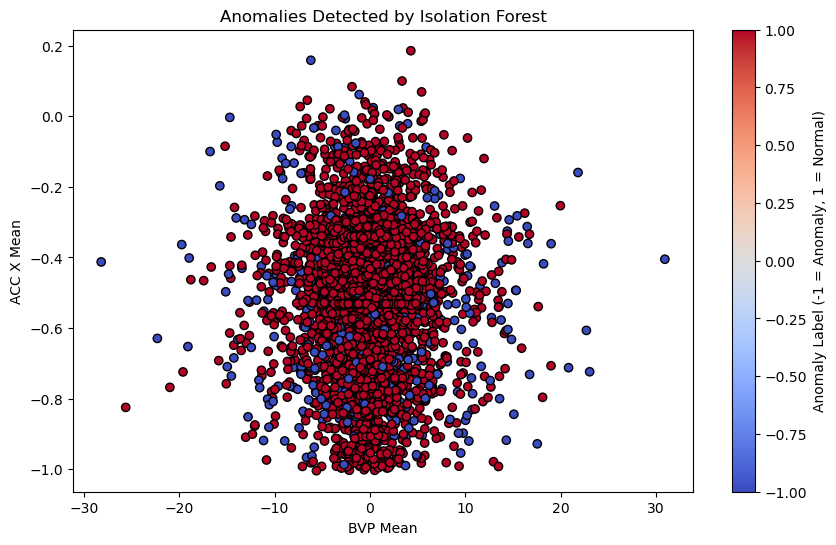

In [60]:
import matplotlib.pyplot as plt

# Scatter plot of two features with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.scatter(features_df["bvp_mean"], features_df["acc_x_mean"], c=features_df["anomaly_label"], cmap="coolwarm", edgecolor="k")
plt.xlabel("BVP Mean")
plt.ylabel("ACC X Mean")
plt.title("Anomalies Detected by Isolation Forest")
plt.colorbar(label="Anomaly Label (-1 = Anomaly, 1 = Normal)")
plt.show()

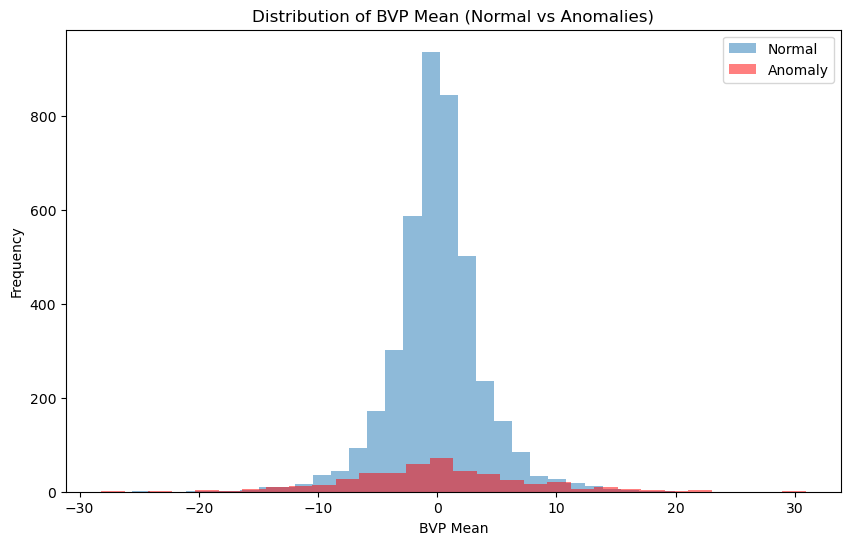

In [63]:
# Compare distributions of BVP Mean
plt.figure(figsize=(10, 6))
plt.hist(features_df[features_df["anomaly_label"] == 1]["bvp_mean"], bins=30, alpha=0.5, label="Normal")
plt.hist(features_df[features_df["anomaly_label"] == -1]["bvp_mean"], bins=30, alpha=0.5, label="Anomaly", color="red")
plt.xlabel("BVP Mean")
plt.ylabel("Frequency")
plt.title("Distribution of BVP Mean (Normal vs Anomalies)")
plt.legend()
plt.show()